Prophet vs SARIMA - Time Series Forecasting

After writing an article on Prophet and SARIMA each, I thought that it would be interesting to compare the projections using the same dataset. In this post, I will try to forecast U.S. industrial production index - an economic indicator that measures real output for all facilities located in the United States manufacturing, mining, and electric, and gas utilities. The output from the two models will be compared using R-squared value (correlation strength) and mean absolute error (the average magnitude of the errors in a set of predictions).

The data and python notebook can be downloaded from my github page.

Importing Data and Libraries

The first step is to import libraries such as fbprophet, statsmodels, sklearn, pandas, numpy, seaborn, matplotlib etc. Please make sure you install these libraries before running the program. To create graphs, we will be using the "fivethirtyeight" styling.

In [41]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

Next, we will import the U.S. industrial production index from Federal Reserve Bank of St. Louis' website and load that data into a pandas dataframe 'data'.

In [42]:
data = pd.read_csv("INDPRO.csv")
# Check the last 5 elements of the dataframe
data.tail()

,DATE,INDPRO
1220,2020-09-01,102.7766
1221,2020-10-01,103.9494
1222,2020-11-01,104.8525
1223,2020-12-01,106.1981
1224,2021-01-01,107.1843


In [43]:
# Check if the the data is set up in proper format and then start modeling/forecasting. 
data.dtypes

DATE       object
INDPRO    float64
dtype: object

The datatype defining the 'DATE' field is an object. Let's convert that into datetime format, a prerequisite of Prophet model.

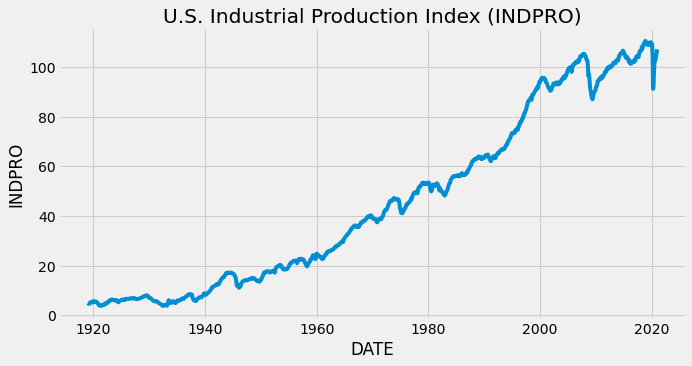

In [44]:
#Convert 'DATE' object to date datatype
data['DATE'] = pd.to_datetime(data['DATE'])
#Visualize the dataframe
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x="DATE", y="INDPRO")
plt.title("U.S. Industrial Production Index (INDPRO)")
plt.grid(True)
plt.show()

Prophet expects that the format of the dataframe to be specific. The model expects a ‘ds’ column  that contains the datetime field and and a ‘y’ column that contains the value we are wanting to model/forecast. Therefore, we need to rename the columns accordingly. Next, we define Prophet's parameters to optimize the model's output. 

In [45]:
data.columns = ["ds","y"]
model = Prophet(growth="linear", seasonality_mode="multiplicative", changepoint_prior_scale=30, seasonality_prior_scale=35,
               daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
               ).add_seasonality(
                name='monthly',
                period=30.5,
                fourier_order=30)

model.fit(data)

Now its time to start forecasting. With Prophet, we start by building some future time data with the following command:

In [46]:
future = model.make_future_dataframe(periods= 120, freq='m')

In this line of code, we created a pandas dataframe with 120 (periods = 120) future data points with a monthly frequency (freq = ‘m’). In the next line of code, we check the last five dates of the forecasted data.

In [47]:
future.tail()

,ds
1340,2030-08-31
1341,2030-09-30
1342,2030-10-31
1343,2030-11-30
1344,2030-12-31


Now, we will try to predict the actual values using Prophet library and check the last five elements of the forecast.

In [48]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1340,2030-08-31,102.459431,85.425796,113.941497,87.687826,116.656677,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,0.0,0.0,0.0,99.802780
1341,2030-09-30,102.475392,85.007095,113.258040,87.487446,116.821815,-0.032729,-0.032729,-0.032729,-0.032729,-0.032729,-0.032729,0.0,0.0,0.0,99.121425
1342,2030-10-31,102.491886,85.024815,114.833022,87.353877,117.042598,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,0.0,0.0,0.0,99.834394
1343,2030-11-30,102.507847,83.923695,113.163477,87.115735,117.367105,-0.032729,-0.032729,-0.032729,-0.032729,-0.032729,-0.032729,0.0,0.0,0.0,99.152818
1344,2030-12-31,102.524341,84.807264,114.659029,86.929732,117.331310,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,-0.025929,0.0,0.0,0.0,99.866007


If we take a look at the data using .tail(), we notice there are a bunch of columns in the forecast dataframe. The important ones (for now) are ‘ds’ (datetime), ‘yhat’ (forecast), ‘yhat_lower’ and ‘yhat_upper’ (uncertainty levels).

In [49]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,1919-01-01,5.175703,2.960490,7.374396
1,1919-02-01,5.182444,2.902753,7.380597
2,1919-03-01,5.043004,2.698701,7.301880
3,1919-04-01,5.002422,2.762295,7.350506
4,1919-05-01,5.033547,2.763458,7.214264


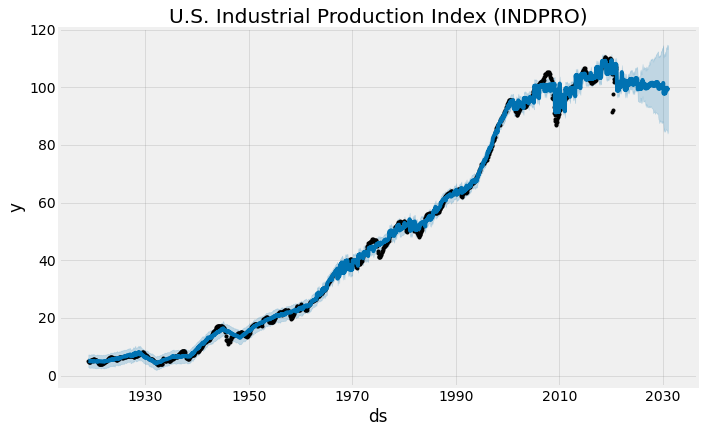

In [50]:
# Plot the graph of this data to get an understanding of how well forecast looks
model.plot(forecast);
plt.title("U.S. Industrial Production Index (INDPRO)")
plt.show()

Next, we will check the model robustness using the best metrics for measuring accuracy of this model. Utilizing a combination of R-Squared, Mean Squared Error and Mean Absolute Error will help us to gauge the quality of our model. We will Python's Scikit-Learn library to quickly calculate these metrics.

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. 

Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

RMSE (Root Mean Squared Error) is the distance, on average, of a data point from the fitted line, measured along a vertical line. The RMSE is directly interpretable in terms of measurement units, and so is a better measure of goodness of fit than a correlation coefficient.

In [51]:
# calculate MAE between expected and predicted values
y_true = data['y'].values
y_pred = forecast['yhat'][:1225].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
r = r2_score(y_true, y_pred)
print('R-squared Score: %.3f' % r)
rms = mean_squared_error(y_true, y_pred, squared=False)
print('RMSE: %.3f' % rms)

MAE: 1.219
R-squared Score: 0.997
RMSE: 1.798


For the U.S. INDPRO time-series data, the Prophet model gives an R-squared value of 0.997 i.e. 99.7% of variance in our data set is explained by the model. The MAE is calculated to be 1.219 i.e. for each data point, the average magnitude error is roughly 1.22% , indicating that our model is robust.

Finally, we create a plot to compare actual vs. predicted values to give a clear understanding of how our model visually looks against the existing U.S. INDPRO dataset.

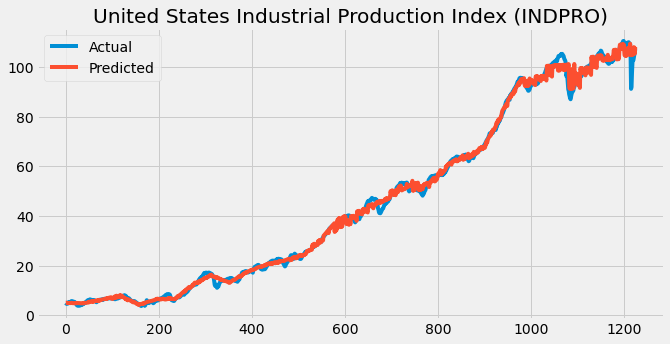

In [52]:
plt.figure(figsize=(10,5))
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("United States Industrial Production Index (INDPRO)")
plt.grid(True)
plt.legend()
plt.show()

SARIMA Model

   Now, let's take a look at how the SARIMA model will perform for the same dataset. The model's notation is SARIMA(p, d, q).(P,D,Q)lag. These three parameters account for seasonality, trend, and noise in data. I tried to calculate the AIC (Akaike information criterion) which is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. We need to select the best combination, that delivers the lowest AIC value. The following program will determine the optimal triplet needed to give the best (P,D,Q) combination between 0 and 2. We will use the itertools library for this short piece of code.

In [53]:
data = pd.read_csv('INDPRO.csv')

# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data['INDPRO'],
                                            order=param,
                                            )

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:13402.14774760819
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11723.74201989737
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11723.74201989737
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2305.0299916689955
ARIMA(0, 1, 0)x(0, 

In [54]:
best_model = SARIMAX(data['INDPRO'], order=(0, 1, 1), seasonal_order=(0, 0, 0, 12)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 INDPRO   No. Observations:                 1225
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1064.852
Date:                Tue, 16 Mar 2021   AIC                           2133.703
Time:                        22:04:40   BIC                           2143.923
Sample:                             0   HQIC                          2137.549
                               - 1225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3835      0.005     79.215      0.000       0.374       0.393
sigma2         0.3335      0.002    170.314      0.000       0.330       0.337
Ljung-Box (L1) (Q):                   0.02   Jarque-

Model Forecast

In the forecast step, we will try to predict the U.S. INDPRO for the next 120 steps i.e. 10 years.

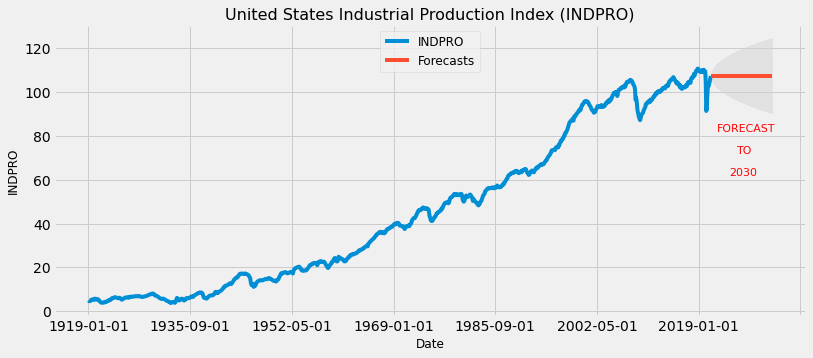

In [55]:
#Forecasting 10 years ahead
forecast_values = best_model.get_forecast(steps = 120)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data.plot(x='DATE' ,y='INDPRO', figsize = (12, 5), legend = True)

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecasts', figsize = (12, 5), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='#D3D3D3', alpha = .5)
plt.title("United States Industrial Production Index (INDPRO)", size=16)
plt.ylabel('INDPRO', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper center', prop={'size': 12})
#annotation
ax.text(1235, 82, 'FORECAST', fontsize=11,  color='RED')
ax.text(1275, 72, 'TO', fontsize=11,  color='RED')
ax.text(1260, 62, '2030', fontsize=11,  color='RED')
plt.show()

Validating the Forecast

To evaluate the model performance, we calculate the R-squared score and the root mean square error of my dataset to test the authenticity of the model. The model has 94.5% accuracy, which is pretty good. Mean Absolute Error of the model is 0.64 and is low enough for us to be confident about the model's ability to predict accurately in the future. 

In [58]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['INDPRO'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['INDPRO'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['INDPRO'], predictions))
evaluation_results

,r2_score,mean_absolute_error,root_mean_squared_error
0,0.945166,0.635354,1.254199


Finally, we compare the actual vs. predicted values to get a clear understanding of the effectiveness of our model. 

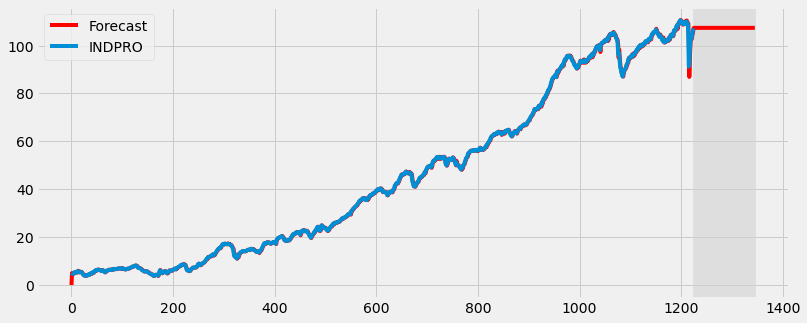

In [57]:
data['sarima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 120)
forecast = data['sarima_model'].append(forecast)
plt.figure(figsize=(12, 5))
plt.plot(forecast, color='r', label='Forecast')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.6, color='lightgrey')
plt.plot(data['INDPRO'], label='INDPRO')
plt.legend()
plt.show()